In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

os.chdir("..")

In [2]:
from pytorch_lightning.loggers import WandbLogger

/home/marco/anaconda3/envs/dl-kit/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import torch
from torch.distributions import Normal, Independent, Distribution, constraints, Transform, TransformedDistribution
from pyro.distributions import ConditionalDistribution





In [4]:
from core.distributions.test import MultivariateCorrelatedNormalMixture

In [5]:
from typing import Callable

import torch
from pyro.distributions import ConditionalDistribution
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Normal, Distribution
from core.distributions.test import MultivariateCorrelatedNormalMixture


In [6]:
device = "cpu"
n_dim = 10
rho = 0.95
epsilon = 0.15
delta = 1.5


p_xy = MultivariateCorrelatedNormalMixture(rho=rho, sigma=0.1, epsilon=epsilon, delta=delta, n_dim=n_dim, device=device)

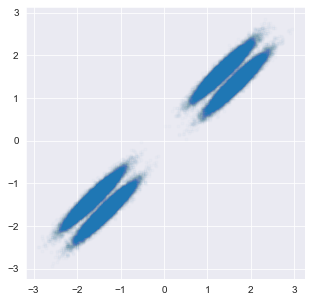

In [7]:
n_samples = 10000
res = 1000
M=6
d = p_xy.sample([n_samples])
x,y = d['x'], d['y']

f, ax =plt.subplots(1,1, figsize=(5,5))

ax.plot(x.view(-1).cpu(), y.view(-1).cpu(), '.', alpha=0.01)

# f, ax =plt.subplots(1,1, figsize=(5,5))
# P = base_dist.log_prob(torch.cat([
#     torch.linspace(-4,4,res).unsqueeze(1).unsqueeze(-1).repeat(1,res,1),
#     torch.linspace(-4,4,res).unsqueeze(0).unsqueeze(-1).repeat(res,1,1)
# ], -1).unsqueeze(-2)).data.numpy()
#
# X, Y = np.meshgrid(np.linspace(-4,4,res),np.linspace(-4,4,res))
#
# P[Y<X]= -100000
#
# plt.contourf(X,Y,P/10, levels=np.linspace(-6,1,6))
# plt.plot([-4,4],[-4,4],'-')

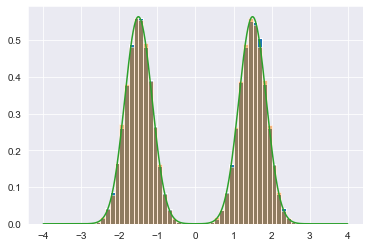

In [8]:
bins = 64
res = 1024

p_x_ = plt.hist(x.view(-1).cpu(), bins=bins, range=[-4,4], density=True)
plt.hist(y.view(-1).cpu(), alpha=0.5, bins=bins, range=[-4,4], density=True)
x = torch.linspace(-4,4, res)
plt.plot(x, p_xy.p_x.log_prob(x.unsqueeze(1))[:,0].exp())

In [9]:
h_y

NameError: name 'h_y' is not defined

In [11]:
n_samples = 1000000
xy = p_xy.sample([n_samples])
x,y = xy['x'], xy['y']
samples = torch.cat([x.unsqueeze(-1), y.unsqueeze(-1)],-1)

n_components=4
h_xy = (-torch.logsumexp(p_xy.component_dist.log_prob(samples.unsqueeze(-2)), -1).mean()+np.log(n_components))*n_dim
h_x = h_y = (-torch.logsumexp(p_xy.x_component_dist.log_prob(samples[:,:,0].unsqueeze(-1)), -1).mean()+np.log(n_components))*n_dim
mi = h_x + h_y - h_xy
mi

tensor(13.6969)

In [11]:
h_y.item()

5.312257289886475

In [12]:
from core.data.datamodule import SampledNormalMixture

data_module = SampledNormalMixture(batch_size=10000)

/home/marco/anaconda3/envs/dl-kit/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [13]:
train_loader = data_module.train_dataloader()

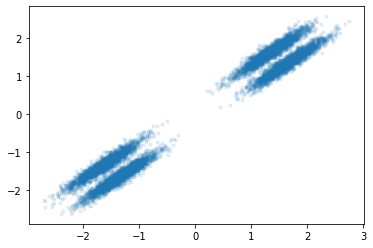

In [14]:
for batch in train_loader:
    break

plt.plot(batch['x'][:,0], batch['y'][:,0], '.', alpha=0.1)

In [15]:
titlesize=15


In [16]:
# Why So Negative!? Better proposals for Mutual Information Estimation and Maximization
h_a

NameError: name 'h_a' is not defined

In [17]:
n_intervals = 2
probs = np.arange(1,n_intervals)*1.0/n_intervals
boundaries = torch.FloatTensor([np.quantile(x.view(-1), p) for p in probs])

In [18]:
from core.distributions.test import SignResampledDistribution
import torch
from torch.distributions import Bernoulli

class ConditionalBernoulli(ConditionalDistribution):
    def __init__(self, t=1e-6, hard=False):
        self.t = t
        self.hard = hard

    def condition(self, x: torch.Tensor):
        if not self.hard:
            logits = x/self.t
            return Bernoulli(logits = logits)
        else:
            return Bernoulli(probs=(x>0).float())


p_a_x = ConditionalBernoulli(hard=True)
# p_xya = AttributeResampledDistribution(p_xy, p_a_x)
p_xya = SignResampledDistribution(p_xy)


In [19]:
from core.data.dataset import SampleDataset

# class Name:
#     def __init__(self, names: List[str]):
#         self.names = names
#
#     def __call__(self, *args):
#         print(args)
#         assert len(self.names) == len(args)
#         return {self.names[i]: arg for i, arg in enumerate(args)}

# from pytorch_lightning import LightningDataModule
#
# class SampledDataModule(LightningDataModule):
#     def __init__(self, batch_size: int, ):

In [20]:
dataset = SampleDataset(p_xya, n_samples=128)

from torch.utils.data import DataLoader

from typing import List, Dict
def collate_fn(batch: List[Dict[str, torch.Tensor]]):
    c_batch = {k:[] for k in batch[0].keys()}

    for item in batch:
        for k, v in item.items():
            c_batch[k].append(v)

    return {k: torch.cat(v, 0) for k,v in c_batch.items()}


train_loader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

In [21]:
for batch in train_loader:
    break

batch["x"].shape

torch.Size([128, 5])

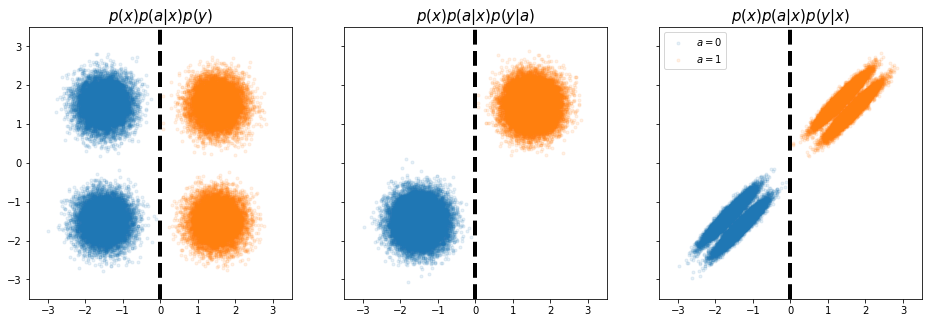

In [22]:
f, ax = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True)
linewidth = 4

n_samples = 10000
xyy_a = p_xya.sample([n_samples])
x,y,y_,a = xyy_a['x'], xyy_a['y'], xyy_a['y_'], xyy_a['a']
y0 = p_xy.sample([n_samples])['y']

ax[0].set_title("$p(x)p(a|x)p(y)$", fontsize=titlesize)
ax[1].set_title("$p(x)p(a|x)p(y|a)$", fontsize=titlesize)
ax[2].set_title("$p(x)p(a|x)p(y|x)$", fontsize=titlesize)

for i in range(2):
    ax[0].plot(x.view(-1)[a.view(-1)==i], y0.view(-1)[a.view(-1)==i], '.', alpha=0.1, label=f"$a={i}$")
    ax[1].plot(x.view(-1)[a.view(-1)==i], y_.view(-1)[a.view(-1)==i], '.', alpha=0.1, label=f"$a={i}$")
    ax[2].plot(x.view(-1)[a.view(-1)==i], y.view(-1)[a.view(-1)==i], '.', alpha=0.1, label=f"$a={i}$")


for i in range(3):
    ax[i].set_xlim(-3.5,3.5)
    ax[i].set_ylim(-3.5,3.5)
    ax[i].axvline(x=0, ls='--', linewidth=linewidth, color="k")

leg = ax[-1].legend()

for l in leg.legendHandles:
    l.set_alpha(1)


In [23]:
p_xya.n_negatives=10

y_ = p_xya.sample([n_samples])["y_"]
a = p_xya.sample([n_samples])["a"]

In [24]:
h_a = np.log(2) * n_dim
h_a

3.4657359027997265

In [25]:
from torch.utils.data import DataLoader






In [27]:
mi

tensor(6.8526)

In [26]:
from core.task.mi_estimation import MutualInformationEstimator
from core.models.ratio import JointRatioEstimator, SeparableRatioEstimator
from pyro.nn import DenseNN
# from core.distributions import conditional_transformed_normal, conditional_mutivariate_categorical
from core.models.predictor import ConditionalCategoricalMLP
from core.models.proposal import TransformedNormalProposal

ModuleNotFoundError: No module named 'core.task.mi_estimation'

In [35]:
hidden_dims = [512, 512]
mi_estimators = {
    # 'cpc': InfoNCE(
    #     ratio_estimator=SeparableRatioEstimator(
    #         f_x=DenseNN(
    #             input_dim=n_dim,
    #             hidden_dims=hidden_dims,
    #             param_dims=[n_dim]
    #         )
    #     )
    # ),
    # 'pcpc': InfoNCE(
    #     ratio_estimator=SeparableRatioEstimator(
    #         f_x=DenseNN(
    #             input_dim=n_dim,
    #             hidden_dims=hidden_dims,
    #             param_dims=[n_dim]
    #         )
    #     ),
    #     proposal=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     h_y=h_y
    # ),
    # 'pnwj': NWJ(
    #     # n_samples=2,
    #     proposal=TransformedNormalProposal(
    #         x_dim=n_dim,
    #         y_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         ),
    #     ),
    #     h_y=h_y
    # ),
    # 'psmile': SMILE(
    #     tau=1.0,
    #     proposal=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     ),
    #     h_y=h_y
    # ),
    # 'pmine': MINE(
    #     proposal=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     ),
    #     h_y=h_y
    # ),
    # 'pjs': JS(
    #     proposal=conditional_transformed_normal(
    #         input_dim=n_dim,
    #         context_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     ),
    #     h_y=h_y
    # ),
    # 'ba': MutualInformationEstimator(
    #     proposal=TransformedNormalProposal(
    #         x_dim=n_dim,
    #         y_dim=n_dim,
    #         hidden_dims=hidden_dims,
    #     ),
    #     h_y=h_y
    # ),
    'anwj': MutualInformationEstimator(
        ratio_estimator=JointRatioEstimator(
            joint_net=DenseNN(
                input_dim=n_dim*2,
                hidden_dims=hidden_dims,
                param_dims=[1]
            ),
        ),
        predictor=ConditionalCategoricalMLP(
            a_dim=n_dim,
            y_dim=n_dim,
            n_classes=2,
            hidden_dims=hidden_dims
        ),
        h_a=h_a
    ),
    # 'nwj': NWJ(
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         ),
    #     ),
    # ),
    # 'flo': FLO(
    #     n_samples=1,
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         ),
    #     ),
    #     joint_baseline=DenseNN(
    #         input_dim=n_dim*2,
    #         hidden_dims=hidden_dims,
    #         param_dims=[1]
    #     )
    # ),
    # #
    # 'mine': MINE(
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),
    # 'smile': SMILE(
    #     tau=1.0,
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),
    # 'js': JS(
    #     ratio_estimator=JointRatioEstimator(
    #         joint_net=DenseNN(
    #             input_dim=n_dim*2,
    #             hidden_dims=hidden_dims,
    #             param_dims=[1]
    #         )
    #     )
    # ),



}
mi_estimators

results = []


MutualInformationEstimator(
  (predictor): ConditionalCategoricalMLP(
    (net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=5, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=512, bias=True)
        (2): Linear(in_features=512, out_features=10, bias=True)
      )
      (f): ReLU()
    )
  )
  (ratio_estimator): JointRatioEstimator(
    (joint_net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=10, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=512, bias=True)
        (2): Linear(in_features=512, out_features=1, bias=True)
      )
      (f): ReLU()
    )
  )
)


In [42]:
mi_estimators["anwj"].predictor.condition(y_).log_prob(a).shape

torch.Size([10000, 10])

In [43]:
from tqdm.auto import tqdm
from torch.optim import Adam
from pytorch_lightning import Trainer
iterations = 50000

logs = []
def log(name, value, **kwargs):
    logs.append({
        "name": name,
        "value": value
    })

for name, mi_estimator in mi_estimators.items():
    print(name)
    mi_estimator.log = log
    opt = Adam(mi_estimator.parameters(), lr=5e-4)

    for iteration in tqdm(range(iterations)):
        batch_size = 128
        batch = p_xya.sample([batch_size])
        x, y, y_, a = batch['x'], batch['y'], batch['y_'], batch['a']

        mi_value, mi_grad = mi_estimator(x, y, y_, a)
        loss = -mi_grad

        opt.zero_grad()
        loss.backward()
        opt.step()
        results.append({
            "estimator": name,
            "iteration": iteration,
            "value": mi_value.item()
        })


anwj


  0%|          | 0/50000 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f4c5dbced30>
Traceback (most recent call last):
  File "/home/marco/anaconda3/envs/dl-kit/lib/python3.8/site-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [44]:
import pandas as pd

pd.DataFrame(logs)

,name,value
0,I_pr(x;y)/train/value,"tensor(-0.0323, grad_fn=<AddBackward0>)"
1,I(x;y)/train/value,"tensor(-0.0391, grad_fn=<AddBackward0>)"
2,KL_f(p||r)/train/value,"tensor(-0.0068, grad_fn=<MeanBackward0>)"
3,KL_f(p||r)/train/grad,"tensor(-0.0068, grad_fn=<MeanBackward0>)"
4,I_pr(x;y)/train/grad,"tensor(-3.4980, grad_fn=<MeanBackward1>)"
...,...,...
9967,I(x;y)/train/value,"tensor(4.8981, grad_fn=<AddBackward0>)"
9968,KL_f(p||r)/train/value,"tensor(1.4326, grad_fn=<MeanBackward0>)"
9969,KL_f(p||r)/train/grad,"tensor(1.4326, grad_fn=<MeanBackward0>)"
9970,I_pr(x;y)/train/grad,"tensor(-0.0002, grad_fn=<MeanBackward1>)"


In [45]:
  # print(name)
  #   opt = Adam(mi_estimator.parameters(), lr=5e-4)
  #   mi_estimator.configure_optimizers = lambda: opt
  #
  #   trainer = Trainer( max_steps=iterations)
  #   trainer.fit(model=mi_estimator, train_dataloaders=train_loader)

In [46]:
import pandas as pd
print(x.shape, y.shape, y_.shape, a.shape)
df_results = pd.DataFrame(results)

torch.Size([128, 5]) torch.Size([128, 5]) torch.Size([128, 10, 5]) torch.Size([128, 10, 5])


In [47]:
# for name, estimator in mi_estimators.items():
#     torch.save(estimator, f"models/{name}.ckpt")

for name, estimator in mi_estimators.items():
    with open(f"models/{name}.ckpt", 'rb') as checkpoint:
        mi_estimators[name] = torch.load(checkpoint)


ModuleNotFoundError: No module named 'core.models.mi_estimators'

anwj


Text(0, 0.5, 'Mutual Information [nats]')

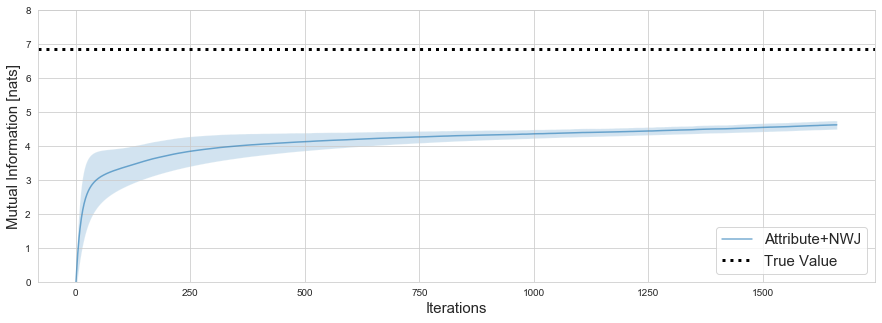

In [48]:
import seaborn as sns
sns.set_style("whitegrid")

f, ax = plt.subplots(1,1, figsize=(15,5))
n_average = 100

EMA_SPAN = 200

name_lookup={
    'ba': 'BA',
    'nwj': 'NWJ',
    'anwj': 'Attribute+NWJ',
    'mine': 'MINE',
    'smile': 'SMILE',
    'flo': 'FLO',
    'psmile': 'Primal+SMILE',
    'js': 'DeepInfoMax',
    'pjs': 'Variational+DeepInfoMax',
    'pnwj': 'Variational+NWJ',
    'pmine': 'Variational+MINE',
    'pcpc': 'Variational+CPC',
    'cpc': 'CPC',
}

for name in df_results.estimator.unique():
    print(name)
    model_results = df_results[df_results["estimator"]==name]
    iterations = model_results["iteration"]
    values = model_results["value"].ewm(EMA_SPAN)

    mi_mean = values.mean()
    mi_std = values.std()
    #mi_std = ((values-mi_mean)**2)[:-n_average//2]**0.5
    # mi_mean = mi_mean[:-n_average//2]

    plt.plot(iterations, mi_mean, '-', alpha=0.6, label=name_lookup[name])
    plt.fill_between(iterations.to_list(), (mi_mean-mi_std).to_list(), (mi_mean+mi_std).to_list(), alpha=0.2, zorder=-1)

plt.axhline(y=mi, color="k", linewidth=3, label='True Value', ls=':')
# plt.axhline(y=np.log(batch_size), color="k", ls='--', linewidth=1, label='$\\log\\ B$')
leg = plt.legend(fontsize=15)
for lh in leg.legendHandles:
    lh._legmarker.set_alpha(1)
plt.ylim(0, 8)
# plt.xlim(0, iterations)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Mutual Information [nats]", fontsize=15)
# sns.despine()

In [1]:
mi

NameError: name 'mi' is not defined

In [23]:
# PrimalMutualInformationEstimator.compute_ratio(mi_estimators["ba"], x,y.unsqueeze(1)), PrimalMutualInformationEstimator.compute_ratio(mi_estimators["pnwj"], x,y.unsqueeze(1)), NWJ.compute_ratio(mi_estimators["pnwj"], x,y.unsqueeze(1)), NWJ.compute_ratio(mi_estimators["nwj"], x,y.unsqueeze(1))

NameError: name 'df_results' is not defined

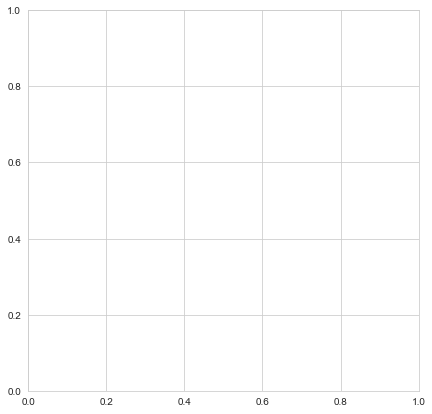

In [24]:

n_batches = 2000

f, ax = plt.subplots(1,1, figsize=(7,7))

offset = 0.0001
for name in df_results.estimator.unique():
    mi_values = []
    mi_estimator = mi_estimators[name]
    mi_estimator.eval()

    for _ in tqdm(range(n_batches)):
        batch_size = 128
        x, y, y_, a = p_xya.sample([batch_size])

        mi_value, mi_grad = mi_estimator(x, y, y_, a)
        mi_values.append(mi_value.item())
    estimated_mi = np.mean(mi_values)
    bias = np.abs(estimated_mi-mi)
    std = np.std(mi_values)

    plt.plot(bias, std, 'o')
    plt.text(bias+offset, std+offset, name_lookup[name], fontsize=15)

# plt.xlim(0)
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Bias [nats]", fontsize=15)
plt.ylabel("Standard Deviation [nats]", fontsize=15)
sns.despine()

In [29]:
res = 512
m, M = -3.5, 3.5

l = np.linspace(m, M, res)
X, Y = np.meshgrid(l,l)
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)
log_p_X = p_xy.p_x.log_prob(torch.FloatTensor(l).unsqueeze(0).unsqueeze(-1).repeat(res,1, n_dim)).sum(-1)
log_p_Y = log_p_X.T
log_p_XY_n = p_xy.log_prob(torch.cat([
    torch.FloatTensor(X).view(-1,1),
    torch.FloatTensor(Y).view(-1,1),
], -1).unsqueeze(1).repeat(1, n_dim, 1)).sum(1).view(res,res)/ n_dim
log_p_X_Y_n = (log_p_X + log_p_Y)/n_dim
dist_results = {}

for name in ["nwj", "anwj", "pnwj"]:
    mi_estimator = mi_estimators[name]
    if mi_estimator.proposal is None:
        if mi_estimator.predictive  is None:
            log_r_Y_X = log_p_Y
        else:
            Y_ = Y.unsqueeze(-1).repeat(1,1,n_dim)
            p_a_Y = mi_estimator.predictive.condition(Y_)
            log_p_A0_Y = p_a_Y.log_prob(torch.zeros(Y_.shape))
            log_p_A0 = log_p_A1 = -n_dim*np.log(2)
            log_p_A1_Y = p_a_Y.log_prob(torch.ones(Y_.shape))
            p_a_X = p_a_x.condition(X)
            log_p_A0_X = p_a_X.log_prob(torch.zeros(X.shape))*n_dim
            log_p_A1_X = p_a_X.log_prob(torch.ones(X.shape))*n_dim

            log_r_Y_X = ((log_p_A0_X+log_p_A0_Y+log_p_Y-log_p_A0).exp() + (log_p_A1_X+log_p_A1_Y+log_p_Y-log_p_A1).exp()).log()
    else:
        r_y_X = mi_estimator.proposal.condition(X.unsqueeze(-1).repeat(1,1,n_dim))
        log_r_Y_X = r_y_X.log_prob(Y.unsqueeze(-1).repeat(1,1,n_dim))

    if mi_estimator.ratio_estimator is None:
        F = X*0
    else:
        F = mi_estimator.ratio_estimator(
            X.unsqueeze(-1).repeat(1, 1, n_dim),
            Y.unsqueeze(-1).repeat(1, 1, n_dim)
        ).T.squeeze()


    log_r_XY = log_r_Y_X + log_p_X

    dist_results[name] = {
        "log r(x,y)": log_r_XY/ n_dim,
        "f(x,y)": F
    }


4.755743248097133e-06 5.273011922836304 5.273016678579552 2197.017794079056
3.4654968976974487 6.411126255989075 9.876623153686523 609.9516182145105
4.615757167339325 6.657769083976746 11.27352625131607 187.80470683706585


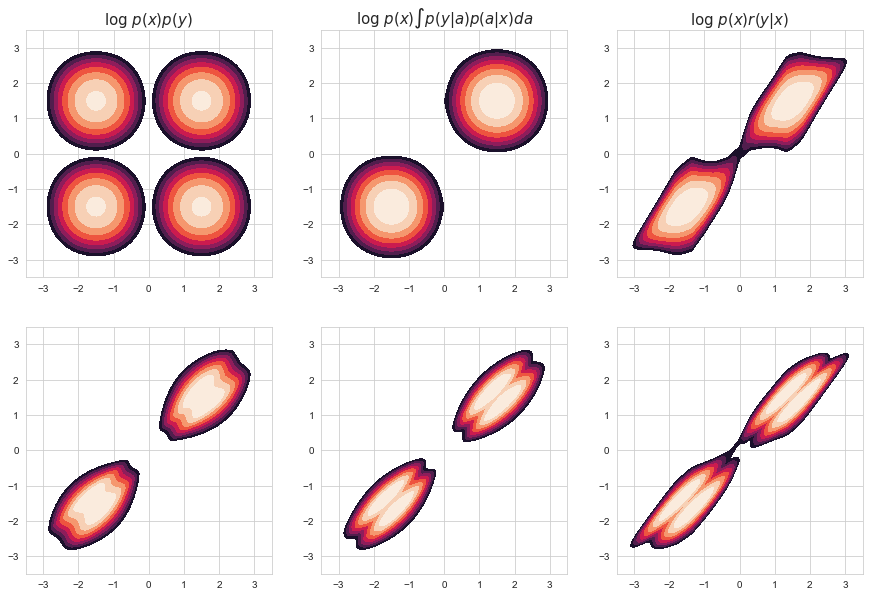

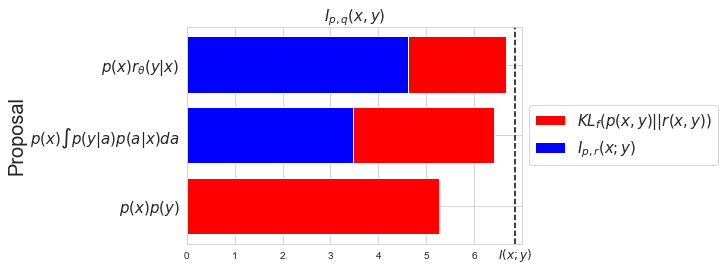

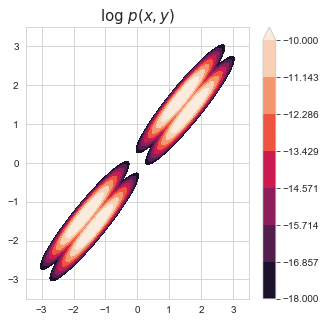

In [131]:
f, ax = plt.subplots(2, len(dist_results), figsize=((len(dist_results))*5, 10))

levels = np.linspace(-18,-10, 8)

log_p_XY_n = log_p_XY_n - torch.logsumexp(log_p_XY_n.view(-1), -1)
log_p_X_Y_n = log_p_X_Y_n - torch.logsumexp(log_p_X_Y_n.view(-1), -1)


p_XY_n = log_p_XY_n.exp()
p_X_Y_n = log_p_X_Y_n.exp()

I_xy = (p_XY_n[p_XY_n>0]*(log_p_XY_n - log_p_X_Y_n)[p_XY_n>0]).sum().item()*n_dim

f2, ax2 = plt.subplots(1,1)

name_lookup = {
    "nwj": "$\\log\\ p(x)p(y)$",
    "anwj": "$\\log\\  p(x)\\int p(y|a)p(a|x) da$",
    "pnwj": "$\\log\\  p(x)r(y|x)$",
}

for i, name in enumerate(dist_results):
    dist = dist_results[name]
    log_r_XY_n = dist['log r(x,y)']
    log_r_XY_n = log_r_XY_n - torch.logsumexp(log_r_XY_n.reshape(-1), -1)

    F = dist['f(x,y)']

    ax[0,i].contourf(X, Y, log_r_XY_n.data.numpy(), levels=levels, extend="max")
    ax[0,i].set_title(name_lookup[name], fontsize=15)

    r_XY_n = log_r_XY_n.exp()

    log_q_XY_n = log_r_XY_n + F/n_dim
    log_q_XY_n = log_q_XY_n - torch.logsumexp(log_q_XY_n.reshape(-1), -1)

    ratio = (log_r_XY_n - log_p_X_Y_n)
    ratio_2 = (log_p_XY_n - log_r_XY_n)
    ratio_3 = (log_q_XY_n - log_p_X_Y_n)

    ax[1,i].contourf(X,Y, log_q_XY_n.data.numpy(), levels=levels, extend="max")

    I_1 = (p_XY_n[p_XY_n>0]*ratio[p_XY_n>0]).sum().item()*n_dim
    I_2 = (p_XY_n[p_XY_n>0]*ratio_3[p_XY_n>0]).sum().item()*n_dim

    mean = (r_XY_n[r_XY_n>0] * F[r_XY_n>0].exp()).sum().item()
    var = (r_XY_n[r_XY_n>0] * (F[r_XY_n>0].exp()-mean)**2).sum().item()*n_dim
    std = var ** 0.5

    # F_ = log_p_XY_n-log_r_XY_n
    #
    # mean_ = (r_XY_n[r_XY_n>0] * F_[r_XY_n>0].exp()).sum().item()
    # var_ = (r_XY_n[r_XY_n>0] * (F_[r_XY_n>0].exp()-mean_)**2).sum().item()*n_dim
    # std_ = var_ ** 0.5

    print(I_1, I_2, I_1+I_2, std)

    # ax2.barh(i,I_xy, color='r', label="$KL(p(x,y)||q(x,y))$" if i==0 else "")
    ax2.barh(i,I_2, color='r', label="$KL_{f}(p(x,y)||r(x,y))$" if i==0 else "")
    ax2.barh(i,I_1, color='b', label="$I_{p,r}(x;y)$" if i==0 else "")

    #
    # if std > 0:
    #     ax[1,-1].bar(i, std, color='b')
    #     # ax[1,-1].bar(i+0.1, std_, color='r')

ax2.axvline(x=I_xy, ls="--", color='k')
ax2.set_yticks([0,1,2])
ax2.set_yticklabels(["$p(x)p(y)$", "$p(x)\\int p(y|a)p(a|x) da$", "$p(x)r_\\theta(y|x)$"], fontsize=15)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
ax2.set_ylabel("Proposal", fontsize=20)
ax2.set_title("$I_{p,q}(x,y)$", fontsize=15)
ax2.text(I_xy,-0.75, "$I(x;y)$", fontsize=12, ha="center")

# ax[0,0].set_ylabel("$r(x,y)$", fontsize=15)
# ax[1,0].set_ylabel("$q(x,y)$", fontsize=15)

# ax[1, -1].set_yscale("log")


f, ax = plt.subplots(1,1, figsize=(5,5))
c = ax.contourf(X,Y,log_p_XY_n, levels=levels, extend="max")
ax.set_title("$\\log\\ p(x,y)$", fontsize=15)
plt.colorbar(c)



(<matplotlib.colorbar.Colorbar at 0x7fb491291700>, 303.55047607421875)

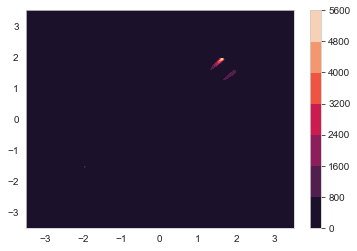

In [286]:
F_ = log_p_XY_n - log_r_XY_n

log_Z = (r_XY_n[r_XY_n>0] * F[r_XY_n>0].exp()).sum()


mean = (r_XY_n[r_XY_n>0] * F[r_XY_n>0].exp()).sum().item()
mean_ = (r_XY_n[r_XY_n>0] * F_[r_XY_n>0]-(F_.mean()).exp()).sum().item()

var = (F_.exp()-mean)**2


epsilon = 1e-4
plt.contourf(X,Y, (r_XY_n*(r_XY_n>epsilon)*(F.exp()-mean)**2).data.numpy())
plt.colorbar(), mean

In [269]:
log_Z

tensor(303.5505, grad_fn=<SumBackward0>)

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


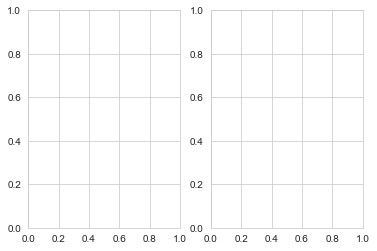

In [267]:
f, ax = plt.subplots(1,2)

levels = np.linspace(-1000, 200, 10)
c=ax[0].contourf(X,Y, (F-F.mean()).data.numpy(), levels=levels)
c = ax[1].contourf(X,Y, F_.data.numpy(), levels=levels)
plt.colorbar(c)


In [255]:
(r_XY_n*(F_.exp()-mean)**2).sum()

tensor(4.3980)

tensor(-0.0015, grad_fn=<SumBackward0>)

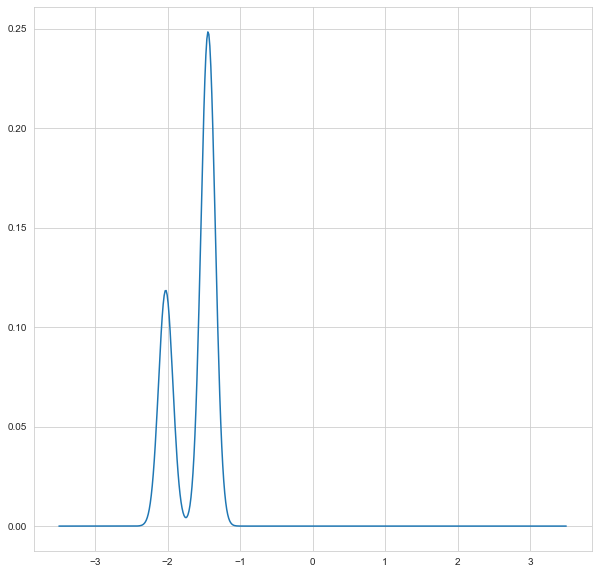

In [175]:
f, ax = plt.subplots(1,1, figsize=(10,10))

row = 128

ax.plot(X[row,:], (log_p_XY[:,row]/n_dim).exp())

(log_p_XY[:,row].exp()*(log_q_XY[:,row]-log_p_XY[:,row])).sum()




In [141]:
mi, I_xy

(tensor(6.8730), 6.594504714012146)

In [56]:
(p_XY[p_XY>0]*dist_results["anwj"]["log r(x,y)"][p_XY>0]).sum(), (p_XY[p_XY>0]*dist_results["nwj"]["log r(x,y)"][p_XY>0]).sum(), p_XY[p_XY>0].sum()

(tensor(-3.9311, grad_fn=<SumBackward0>), tensor(-7.3969), tensor(1.))

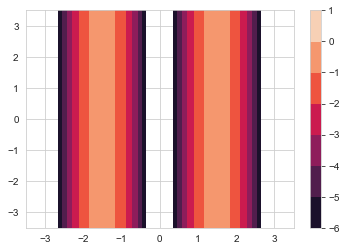

In [134]:
plt.contourf(X,Y, log_p_X/n_dim, levels=levels)
plt.colorbar()

# Barber-Agakov

In [135]:
estimator = mi_estimators['ba']
r_y_x = estimator.proposal

r_y_X = r_y_x.condition(torch.FloatTensor(l).unsqueeze(-1).repeat(1,n_dim))
r_Y_X = r_y_X.log_prob(torch.FloatTensor(l).unsqueeze(1).unsqueeze(-1).repeat(1,1,n_dim)).data.numpy()


dist_results.append({
    "estimator": "ba",
    "log r(y|x)": r_Y_X,
    "f(x,y)": r_Y_X*0,
    }
)


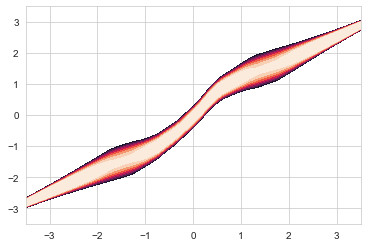

In [136]:
plt.contourf(X,Y, r_Y_X, levels=levels, extend="max")

# Dual

In [137]:
log_p_Y = p_xy.p_x.log_prob(torch.FloatTensor(l).unsqueeze(0).repeat(res,1).unsqueeze(-1)).sum(-1).T

for name in [ "nwj", "mine", "js", "cpc", "smile", "flo"]:
    if name not in mi_estimators:
        continue
    estimator = mi_estimators[name]

    r_Y_X = log_p_Y
    f_X_Y = estimator.ratio_estimator(
        torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
        torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).T.squeeze()

    # if name == 'cpc':
    #     f_X_Y -= torch.logsumexp(f_X_Y, -1).unsqueeze(-1)-2*np.log(res)

    dist_results.append({
        "estimator": name,
        "log r(y|x)": r_Y_X.data.numpy(),
        "f(x,y)": f_X_Y.data.numpy(),
        }
    )


In [138]:
for name in [ "flo"]:
    if name not in mi_estimators:
        continue
    estimator = mi_estimators[name]

    r_Y_X = p_xy.p_x.log_prob(torch.FloatTensor(l).unsqueeze(0).repeat(res,1).unsqueeze(-1)).sum(-1).T
    f_X_Y = estimator.baseline(None,
        torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
        torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).T.squeeze()

    # if name == 'cpc':
    #     f_X_Y -= torch.logsumexp(f_X_Y, -1).unsqueeze(-1)-2*np.log(res)

    dist_results.append({
        "estimator": name,
        "log r(y|x)": r_Y_X.data.numpy(),
        "f(x,y)": f_X_Y.data.numpy(),
        }
    )

In [80]:
for name in ["anwj"]:
    if name not in mi_estimators:
        continue
    estimator = mi_estimators[name]

    Y_ = torch.Tensor(Y).unsqueeze(-1).repeat(1,1,n_dim)
    p_a_Y = estimator.predictive.condition(Y_)
    log_p_A0_Y = p_a_Y.log_prob(torch.zeros(Y_.shape))
    log_p_A0 = log_p_A1 = -n_dim*np.log(2)
    log_p_A1_Y = p_a_Y.log_prob(torch.ones(Y_.shape))

    log_p_A0_X = p_a_x.condition(torch.tensor(X)).log_prob(torch.zeros(X.shape))*n_dim
    log_p_A1_X = p_a_x.condition(torch.tensor(X)).log_prob(torch.ones(X.shape))*n_dim

    r_Y_X = ((log_p_A0_X+log_p_A0_Y+log_p_Y-log_p_A0).exp() + (log_p_A1_X+log_p_A1_Y+log_p_Y-log_p_A1).exp()).log()
    f_X_Y = estimator.ratio_estimator(
        torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
        torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).T.squeeze()

    # if name == 'cpc':
    #     f_X_Y -= torch.logsumexp(f_X_Y, -1).unsqueeze(-1)-2*np.log(res)

    dist_results.append({
        "estimator": name,
        "log r(y|x)": r_Y_X.data.numpy(),
        "f(x,y)": f_X_Y.data.numpy(),
        }
    )

<ipython-input-80-d24263dd95c7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_p_A0_X = p_a_x.condition(torch.tensor(X)).log_prob(torch.zeros(X.shape))*n_dim
<ipython-input-80-d24263dd95c7>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_p_A1_X = p_a_x.condition(torch.tensor(X)).log_prob(torch.ones(X.shape))*n_dim


AttributeError: 'dict' object has no attribute 'append'

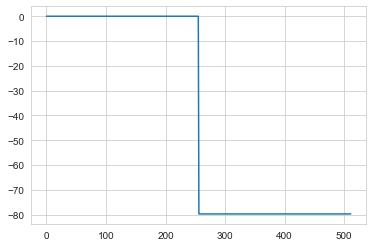

In [140]:
plt.plot(log_p_A0_X[0,:])

In [141]:
p_a_Y.log_prob(torch.zeros(Y_.shape)).shape

torch.Size([512, 512])

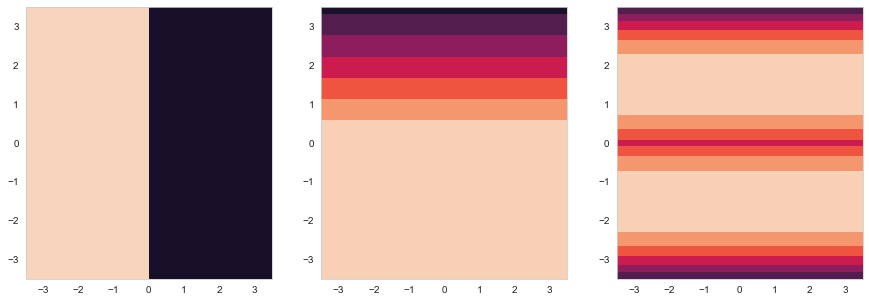

In [142]:
f, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].contourf(X,Y,log_p_A0_X)
ax[1].contourf(X,Y,log_p_A0_Y.data.numpy())
ax[2].contourf(X,Y,log_p_Y)

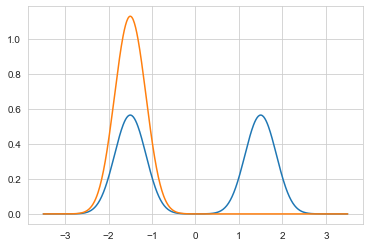

In [143]:
plt.plot(Y[:,0], np.exp(log_p_Y[:,0]/n_dim))
plt.plot(Y[:,0], np.exp(r_Y_X.data.numpy()[:,0]/n_dim))

In [144]:
torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim).shape,torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim).shape, f_X_Y.shape

(torch.Size([512, 5]), torch.Size([512, 512, 5]), torch.Size([512, 512]))

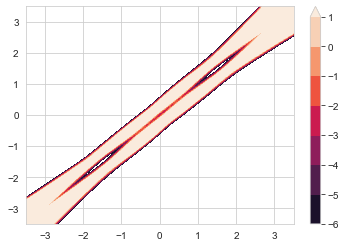

In [145]:
plt.contourf(X,Y, f_X_Y.data.numpy(), extend="max", levels=levels)
plt.colorbar()

# Primal+Dual

In [146]:
for name in ["pnwj", "pmine", "psmile", "pjs", "pcpc"]:
    if name not in mi_estimators:
        continue
    estimator = mi_estimators[name]

    r_Y_X = estimator.proposal.condition(torch.FloatTensor(l).unsqueeze(-1).repeat(1,n_dim)).log_prob(
        torch.FloatTensor(l).unsqueeze(1).unsqueeze(-1).repeat(1,1,n_dim)
    ).data

    f_X_Y = estimator.ratio_estimator(
        torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
        torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).T.squeeze()

    dist_results.append({
        "estimator": name,
        "log r(y|x)": r_Y_X.data.numpy(),
        "f(x,y)": f_X_Y.data.numpy(),
        }
    )


In [147]:
# estimator = mi_estimators[name]
#
# r_X_Y = Normal(0,1).log_prob(torch.FloatTensor(l)).unsqueeze(0).repeat(res,1)
# f_X_Y = estimator.ratio_estimator(
#     torch.Tensor(l).unsqueeze(-1).repeat(1, n_dim),
#     torch.Tensor(l).unsqueeze(0).unsqueeze(-1).repeat(res, 1, n_dim)).squeeze()
#
# # q_x_y = estimator.r_x_y
# #
# # q_x_Y = q_x_y.condition(torch.FloatTensor(l).unsqueeze(-1).repeat(1,n_dim))
# # q_X_Y = q_x_Y.log_prob(torch.FloatTensor(l).unsqueeze(1).unsqueeze(-1).repeat(1,1,n_dim)).data
#
# log_Z = torch.logsumexp((f_X_Y + r_X_Y), 0).mean()-np.log(res)
#
# dist_results.append({
#     "estimator": name,
#     "log r(x|y)": r_X_Y.data.numpy(),
#     "f(x,y) - log Z": (f_X_Y-log_Z).data.numpy(),
#     }
# )


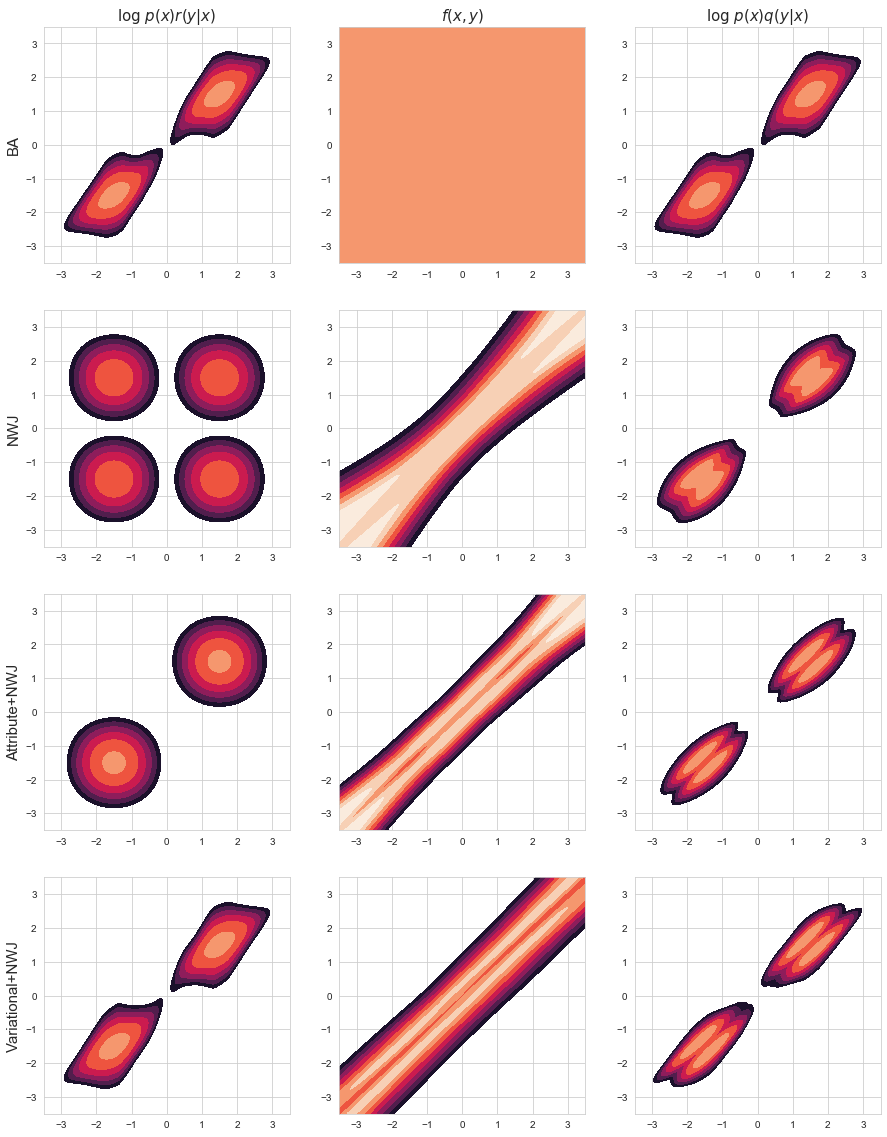

In [148]:
imgsize=5
f, ax = plt.subplots(len(dist_results), 3, figsize=(imgsize*3, imgsize*len(dist_results)))

if ax.ndim==1:
    ax = ax.reshape(1,-1)

ax[0,0].set_title("$\\log\\ p(x)r(y|x)$", fontsize=15)
ax[0,1].set_title("$f(x,y)$", fontsize=15)
# ax[0,2].set_title("$\\log\\ q(y|x) $", fontsize=15)
ax[0,2].set_title("$\\log\\ p(x)q(y|x)$", fontsize=15)

levels = np.linspace(-8,2, 8)

log_p_XY = p_xy.log_prob(torch.cat([
    torch.FloatTensor(X).view(-1,1),
    torch.FloatTensor(Y).view(-1,1),
], -1).unsqueeze(1).repeat(1,n_dim, 1)).sum(1).view(res,res).data.numpy()

for i, dist_result in enumerate(dist_results):
    log_r_Y_X = dist_result["log r(y|x)"]
    f = dist_result["f(x,y)"]
    # f_clamp = torch.clamp(torch.FloatTensor(dist_result["f(x,y)"]), -1000, 1000).data.numpy()

    # log_Z_r = torch.logsumexp(torch.FloatTensor(log_r_Y_X + log_p_X).view(-1), 0).item()
    # log_Z_q = torch.logsumexp(torch.FloatTensor(log_r_Y_X + f + log_p_X).reshape(-1), 0).item()

    ax[i,0].contourf(X, Y, (log_r_Y_X+log_p_X) / n_dim, levels=levels, extend="max")
    ax[i,1].contourf(X,Y, f/n_dim , levels=levels, extend="max")
    # c = ax[i,2].contourf(X, Y, (f + log_r_Y_X) / n_dim, levels=levels, extend="max")
    ax[i,2].contourf(X, Y, (log_p_X + log_r_Y_X + f) / n_dim, levels=levels, extend="max")
    # ax[i,3].contourf(X, Y, (log_p_XY - log_p_X - log_r_Y_X) / n_dim, levels=levels, extend="max")
    ax[i,0].set_ylabel(name_lookup[dist_result["estimator"]], fontsize=15)


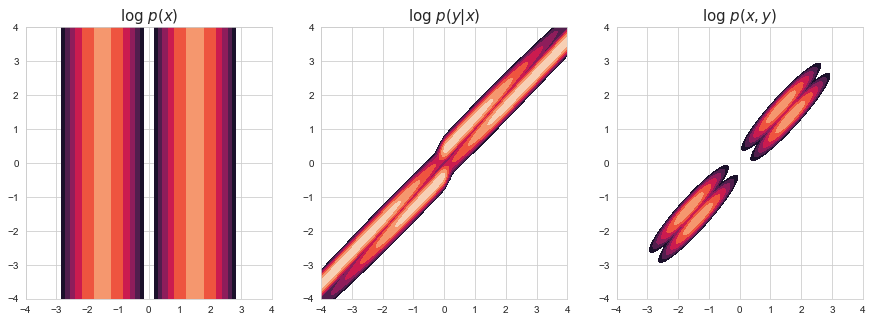

In [88]:
f, ax = plt.subplots(1,3, figsize=(3*imgsize, imgsize))

ax[0].set_title("$\\log\\ p(x) $", fontsize=15)
ax[1].set_title("$\\log\\ p(y|x) $", fontsize=15)
ax[2].set_title("$\\log\\ p(x,y) $", fontsize=15)


log_p_XY = p_xy.log_prob(torch.cat([
    torch.FloatTensor(X).view(-1,1),
    torch.FloatTensor(Y).view(-1,1),
], -1).unsqueeze(1).repeat(1,n_dim, 1)).sum(1).view(res,res).data.numpy()

# log_Z_X = torch.logsumexp(log_p_X.reshape(-1), -1)
# log_Z_XY = torch.logsumexp(log_p_XY.view(-1), -1)

ax[0].contourf(X,Y, log_p_X/n_dim, levels=levels)
ax[1].contourf(X,Y, (log_p_XY-log_p_X)/n_dim, levels=levels)
ax[2].contourf(X,Y, log_p_XY/n_dim, levels=levels)

In [64]:
log_p_X

array([[-143.82942, -141.99588, -140.17462, ..., -140.17462, -141.99588,
        -143.82942],
       [-143.82942, -141.99588, -140.17462, ..., -140.17462, -141.99588,
        -143.82942],
       [-143.82942, -141.99588, -140.17462, ..., -140.17462, -141.99588,
        -143.82942],
       ...,
       [-143.82942, -141.99588, -140.17462, ..., -140.17462, -141.99588,
        -143.82942],
       [-143.82942, -141.99588, -140.17462, ..., -140.17462, -141.99588,
        -143.82942],
       [-143.82942, -141.99588, -140.17462, ..., -140.17462, -141.99588,
        -143.82942]], dtype=float32)

In [65]:
x, y = torch.chunk(p_xy.sample([1000000]), 2, -1)
x = x.squeeze()
y = y.squeeze()

x_ = mi_estimators["pnwj"].sample_negatives(x,y.unsqueeze(1))
#
# plt.plot(x[:,0], y[:,0], '.', label='p(x|y)', alpha=0.1)
# plt.plot(x_[:,0,0], y[:,0], '.', label='r(x|y)', alpha=0.1)
# plt.legend(fontsize=15)

TypeError: chunk(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:
m = -4
M = 4
res = 32
X, Y = np.meshgrid(np.linspace(m,M, res),np.linspace(m,M, res))
density, _, _ = np.histogram2d(x[:,0].data.numpy(), y[:,0].data.numpy(), range=[[m,M],[m,M]], bins=res)
density_2, _, _ = np.histogram2d(x_[:,0,0].data.numpy(), y[:,0].data.numpy(), range=[[m,M],[m,M]], bins=res)

f_ = mi_estimators["pnwj"].ratio_estimator(
    torch.linspace(m,M,res).unsqueeze(-1).repeat(1,n_dim),
    torch.linspace(m,M,res).unsqueeze(0).unsqueeze(-1).repeat(res,1,n_dim)).squeeze().data.numpy()

log_Z = (mi_estimators["pnwj"].ratio_estimator(x_[:2048],y[:2048].unsqueeze(1))-1).exp().mean().item()

fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].contourf(X,Y, density)
ax[1].contourf(X,Y, density_2)
c = ax[2].contourf(X,Y, density/density_2, levels=[0,0.9,1.1,2])
c = ax[3].contourf(X,Y, f_+log_Z, levels=[0,0.9,1.1,2])

ax[0].set_title("$p(x,y)$", fontsize=15)
ax[1].set_title("$r(x|y)p(y)$", fontsize=15)
ax[2].set_title("$p(x|y)/r(x|y)$", fontsize=15)
ax[3].set_title("$f(x,y)+\\log Z$", fontsize=15)

fig.colorbar(c, ax=ax[3])


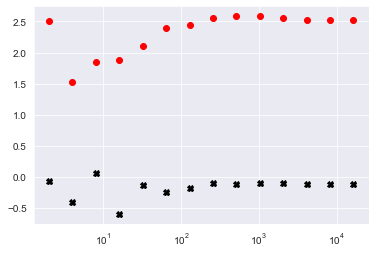

In [32]:
for i in range(1,15):
    s_x = x[:2**i]
    s_y = y[:2**i].unsqueeze(1)
    s_x_ = mi_estimators["pnwj"].sample_negatives(s_x,s_y)
    f_ = mi_estimators["pnwj"].ratio_estimator(s_x_,s_y)
    f = mi_estimators["pnwj"].ratio_estimator(s_x,s_y)
    b = mi_estimators["pnwj"].baseline(f_, y).unsqueeze(1)
    n = torch.FloatTensor(f).mean() - (f_-1).exp().mean()
    n_,_ = NWJ.forward(mi_estimators["pnwj"], s_x, s_y)


    plt.plot(2**i, n.item(), 'Xk')
    plt.plot(2**i, n_.item(), 'or')

plt.xscale("log")

In [23]:
f_.shape, s_x.shape, s_y.shape, s_x_.shape,

(torch.Size([16384, 1, 1]),
 torch.Size([16384, 2]),
 torch.Size([16384, 1, 2]),
 torch.Size([16384, 1, 2]))

In [26]:
.shape

torch.Size([16384, 1])

(tensor(1.1730, grad_fn=<MeanBackward0>),
 tensor(1.3298, grad_fn=<MeanBackward0>))

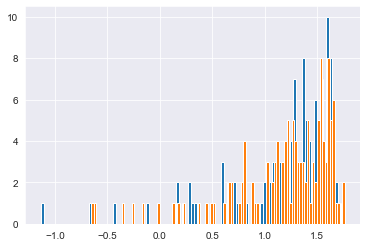

In [50]:
f = mi_estimators['pnwj'].ratio_estimator(x,y.unsqueeze(1))
f_ = mi_estimators['pnwj'].ratio_estimator(x_,y.unsqueeze(1))


plt.hist(f.view(-1).data, bins=100);
plt.hist(f_.view(-1).data, bins=100);

f.mean(), (f_-1).exp().mean()

In [102]:
mi_estimator = mi_estimators["smile"]
mi_estimator.eval()

mi_values = []
for _ in tqdm(range(n_batches)):
    batch_size = 128
    x, y = torch.chunk(p_xy.sample([batch_size]), 2, -1)
    x = x.squeeze()
    y = y.squeeze()
    for tau in np.linspace(0, 10, 10):
        mi_estimator.tau=tau
        mi_value, _ = mi_estimator(x,y)
        mi_values.append(
            {
                "value": mi_value.item(),
                "tau": tau
            })



KeyError: 'smile'

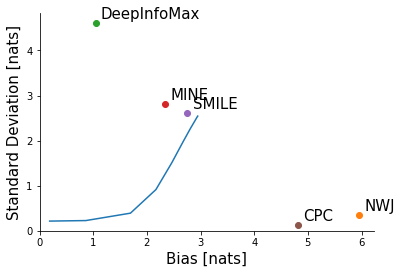

In [81]:
smile_values = pd.DataFrame(mi_values).groupby(["tau"]).aggregate(['mean','std']).reset_index()
plt.plot(np.abs(smile_values["value","mean"].values-mi),smile_values["value","std"].values)


for name in results.estimator.unique():
    mi_values = []
    mi_estimator = mi_estimators[name]
    mi_estimator.eval()

    for _ in tqdm(range(n_batches)):
        batch_size = 128
        x, y = torch.chunk(p_xy.sample([batch_size]), 2, -1)
        x = x.squeeze()
        y = y.squeeze()

        mi_value, _ = mi_estimator(x,y)
        mi_values.append(mi_value.item())
    estimated_mi = np.mean(mi_values)
    bias = np.abs(estimated_mi-mi)
    std = np.std(mi_values)

    plt.plot(bias, std, 'o')
    plt.text(bias+offset, std+offset, name_lookup[name], fontsize=15)

plt.xlim(0)
plt.ylim(0)
plt.xlabel("Bias [nats]", fontsize=15)
plt.ylabel("Standard Deviation [nats]", fontsize=15)
sns.despine()

plt.xlim(0)
plt.ylim(0)
plt.xlabel("Bias [nats]", fontsize=15)
plt.ylabel("Standard Deviation [nats]", fontsize=15)
sns.despine()

In [79]:
np.abs(smile_values["value","mean"]-mi)

0    0.187909
1    0.862464
2    1.693506
3    2.168220
4    2.464533
5    2.673230
6    2.811783
7    2.892598
8    2.930922
9    2.947360
Name: (value, mean), dtype: float64

In [12]:
mi_estimators['smile'].baseline

AttributeError: 'SMILE' object has no attribute 'baseline'

In [ ]:
y_ = mi_estimators['nwj'].sample_negatives(x,y)
plt.plot(y[0,0], y[0,1],'o')
plt.plot(y_[1,:,0], y_[1,:,1], '.')

In [ ]:
f_ = mi_estimators['cpc'].ratio_estimator(x,y_)
f = mi_estimators['cpc'].ratio_estimator(x,y)
a = mi_estimators['cpc'].baseline(f_,x)
f.shape, f_.shape

In [ ]:
import math
(torch.logsumexp(f_, 1)-np.log(x.shape[0])).mean(), a.mean(), mi_estimators['cpc'].compute_normalization(f_,x,y)

In [ ]:
plt.axhline(mi, color='k', ls='--')
    N = 10000
    values = np.nan_to_num(mi_values)
    # values[values > 100] = 100
    # values[values < -500] = -500

In [ ]:
consider_last = 10000
values[-consider_last:].mean(), values[-consider_last:].std(), mi

In [17]:
consider_last = 10000
values[-consider_last:].mean(), values[-consider_last:].std(), mi

(16.662906572914125, 0.3977542873183761, tensor(11.6395))

In [14]:
from core.distributions.utils import conditional_transformed_normal

x_dim = y_dim = 10
hidden_dims = [32, 32]

dist = conditional_transformed_normal(
    input_dim=x_dim,
    context_dim=y_dim,
    hidden_dims=hidden_dims,
)

In [15]:
mi_estimator.r_x_y.condition(torch.zeros(128, 10)).sample().shape

torch.Size([128, 10])